# 验证3-逐步搭建多层神经网络
--------
## 介绍

在本练习中，我们要构建两个神经网络，一个是构建两层的神经网络，一个是构建多层的神经网络，多层神经网络的层数可以自己定义。

在开始练习前，需要**介绍如下的文件**：

- testCases3.py -提供了一些测试示例来评估函数的正确性
- dnn_utils.py -提供激活函数和激活函数的导数计算等功能函数


在整个练习中，涉及如下的**必做作业**：

| 作业                    | 分值  |
|-----------------------|-----|
| [初始化多层神经网络模型参数](#1)   | 10分 |
| [实现多层神经网络模型的前向传播](#2) | 30分 |
| [实现代价函数](#3)          | 10分 |
| [实现多层神经网络模型的反向传播](#4) | 20分 |
| [实现参数更新函数](#5)        | 10分 |
| [搭建多层神经网络](#6)        | 20分 |

## 1 逐步搭建神经网络
在本部分练习中，我们将逐步的搭建一个多层的神经网络模型。对于多层神经网络模型，其结构为`输入层->隐藏层->隐藏层->...->输出层`，则其中会涉及到一个转发函数，即线性向非线性转发的一个激活函数。

在每一层中，我们将先进行一个线性部分的计算$Z = np.dot(W,A)+b$，接着再计算线性激活部分$A=relu(Z)$或者$A=sigmoid(Z)$，合起来就是一个层的计算。

因此，构建完整的多层神经网络模型步骤为：
1. 初始化网络参数
2. 前向传播
    1. 实现计算一层中的线性求和部分
    2. 实现计算激活函数(在本练习中我们设定relu函数使用L-1次，sigmoid函数使用1次，L为模型的层数）
    3. 合并线性求和与激活函数
3. 计算代价
4. 反向传播
    1. 线性部分的反向传播
    2. 激活函数的反向传播
    3. 合并线性部分和激活函数的反向传播
5. 更新参数

在神经网络中，每一层的前向计算都对应着一个反向计算，在我们进行前向计算过程中会存储一些值(a1,z1,a2,z2...)，这些值将用于反向计算梯度。
在正式开始之前，导入我们需要的python库文件。


In [33]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

import testCases3
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward


def load_dataset():
    train_dataset = h5py.File('./data/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])  # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # your train set labels

    test_dataset = h5py.File('./data/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])  # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # your test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


### 1.1 初始化参数<span id='1'></span>
接下来，我们需要构建初始化参数的函数，首先我们以两层神经网络结构为例。

两层的神经网络模型的结构为`（隐藏层）线性->relu->（输出层）线性->sigmoid`。其结构也类似于之前练习所做过的单隐层神经网络模型。
对于两层神经网络模型的初始化参数函数如下：


In [34]:
def initialize_parameters(n_x, n_h, n_y):
    """
    此函数是为了初始化两层网络参数而使用的函数。
    参数：
        n_x - 输入层节点数量
        n_h - 隐藏层节点数量
        n_y - 输出层节点数量
    
    返回：
        parameters - 包含你的参数的python字典：
            W1 - 权重矩阵,维度为（n_h，n_x）
            b1 - 偏向量，维度为（n_h，1）
            W2 - 权重矩阵，维度为（n_y，n_h）
            b2 - 偏向量，维度为（n_y，1）

    """
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    #使用断言确保我的数据格式是正确的
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [35]:
print("==============测试initialize_parameters==============")
parameters = initialize_parameters(3, 2, 1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

==============测试initialize_parameters==============
W1 = [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1 = [[0.]
 [0.]]
W2 = [[ 0.01744812 -0.00761207]]
b2 = [[0.]]


在上述的初始化参数函数中，我们对两层神经网络模型中的变量`w1,b1,w2,b2`进行了初始化，并设定了对应的形状，确保其矩阵形状符合计算要求。

接下来，你需要**实现对于多层（L层）神经网络的初始化参数函数initialize_parameters_deep()**。

**要点**：
- 仿照`initialize_parameters()`函数设计并实现多层神经网络模型的参数初始化
- 函数的参数列表及返回值需要符合函数说明
- 注意对于多层神经网络模型，各层的参数矩阵形状需要符合计算要求。

In [36]:
def initialize_parameters_deep(layers_dims):
    """
    此函数是为了初始化多层网络参数而使用的函数。
    参数：
        layers_dims - 包含我们网络中每个图层的节点数量的列表
    
    返回：
        parameters - 包含参数“W1”，“b1”，...，“WL”，“bL”的字典：
                     W1 - 权重矩阵，维度为（layers_dims [1]，layers_dims [1-1]）
                     bl - 偏向量，维度为（layers_dims [1]，1）
    """
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims)

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) / np.sqrt(layers_dims[l - 1])
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

        #确保我要的数据的格式是正确的
        assert (parameters["W" + str(l)].shape == (layers_dims[l], layers_dims[l - 1]))
        assert (parameters["b" + str(l)].shape == (layers_dims[l], 1))

    return parameters


In [37]:
#测试initialize_parameters_deep
print("==============测试initialize_parameters_deep==============")
layers_dims = [5, 4, 3]
parameters = initialize_parameters_deep(layers_dims)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

==============测试initialize_parameters_deep==============
W1 = [[ 0.79989897  0.19521314  0.04315498 -0.83337927 -0.12405178]
 [-0.15865304 -0.03700312 -0.28040323 -0.01959608 -0.21341839]
 [-0.58757818  0.39561516  0.39413741  0.76454432  0.02237573]
 [-0.18097724 -0.24389238 -0.69160568  0.43932807 -0.49241241]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.59252326 -0.10282495  0.74307418  0.11835813]
 [-0.51189257 -0.3564966   0.31262248 -0.08025668]
 [-0.38441818 -0.11501536  0.37252813  0.98805539]]
b2 = [[0.]
 [0.]
 [0.]]


### 1.2 前向传播

回顾在最开始时所讲述的，对于两层的神经网络模型，每一层的计算都包含一个线性计算和一个非线性激活计算，在本练习中默认使用relu，在输出层使用sigmoid。

而对于多层神经网络模型，需要考虑L-1层和L层之间的计算关系，其计算步骤为：
`【线性->relu】（1层）->...->【线性->relu】（L-1层）->【线性->sigmoid】（输出层）`
#### 1.2.1 线性部分实现

在前向传播中，线性部分的向量化计算公式如下：

$$Z^{[l]} = W^{[l]}A^{[l-1]}+b^{[l]}$$

In [38]:
def linear_forward(A, W, b):
    """
    实现前向传播的线性部分。

    参数：
        A - 来自上一层（或输入数据）的激活，维度为(上一层的节点数量，示例的数量）
        W - 权重矩阵，numpy数组，维度为（当前图层的节点数量，前一图层的节点数量）
        b - 偏向量，numpy向量，维度为（当前图层节点数量，1）

    返回：
         Z - 激活功能的输入，也称为预激活参数
         cache - 一个包含“A”，“W”和“b”的字典，存储这些变量以有效地计算后向传递
    """
    Z = np.dot(W, A) + b
    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache

In [39]:
#测试linear_forward
print("==============测试linear_forward==============")
A, W, b = testCases3.linear_forward_test_case()
Z, linear_cache = linear_forward(A, W, b)
print("Z = " + str(Z))

==============测试linear_forward==============
Z = [[ 3.26295337 -1.23429987]]


#### 1.2.2 非线性激活部分实现
接下来，我们需要构建前向传播中的激活部分，在这个函数中我们将会包含线性部分的计算，并用于激活部分的参数。其中，激活部分的函数实现有：
- sigmoid：$\sigma(Z) = \sigma(WA+b) = \frac{1}{1+e^{-(WA+b)}}$
- relu: $A= RELU(Z) = max(0,Z)$

In [40]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    实现LINEAR-> ACTIVATION 这一层的前向传播

    参数：
        A_prev - 来自上一层（或输入层）的激活，维度为(上一层的节点数量，示例数）
        W - 权重矩阵，numpy数组，维度为（当前层的节点数量，前一层的大小）
        b - 偏向量，numpy阵列，维度为（当前层的节点数量，1）
        activation - 选择在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】

    返回：
        A - 激活函数的输出，也称为激活后的值
        cache - 一个包含“linear_cache”和“activation_cache”的字典，我们需要存储它以有效地计算后向传递
    """

    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [41]:
#测试linear_activation_forward
print("==============测试linear_activation_forward==============")
A_prev, W, b = testCases3.linear_activation_forward_test_case()

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation="sigmoid")
print("sigmoid，A = " + str(A))

A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation="relu")
print("ReLU，A = " + str(A))

==============测试linear_activation_forward==============
sigmoid，A = [[0.96890023 0.11013289]]
ReLU，A = [[3.43896131 0.        ]]


#### 1.2.3 多层神经网络的前向传播函数实现<span id='2'></span>
至此，我们已经实现对于两层神经网络模型的前向传播函数。那么多层网络模型的前向传播又该如何实现呢？

在多层网络模型的实现中，每一层的实现都可以调用上述两个函数进行，使得计算更加方便。

![](data/3-1.png)

在实现L层网络模型时：
- 每个隐藏层都需要使用激活函数为relu的前向传播函数进行计算，并存储前一层计算得到的参数。
- 在输出层，使用激活函数为sigmoid的前向传播函数来进行计算。

对于第m层的的计算公式为：
$$A^{[m]} = \sigma(Z^{[m]}) = \sigma(W^{[m]}A^{[m-1]}+b^{[m]})$$
其中，当m=L时，$\sigma$为sigmoid函数；否则$\sigma$为relu函数。

接下来，你需要**实现L_model_forward()函数，用于多层神经网络模型的前向传播**。

**要点**：
- 依据上述讲解进行函数实现
- 函数的参数列表和返回值详见函数说明
- 预期的测试结果应为：
```shell
AL = [[ 0.17007265  0.2524272 ]]
caches 的长度为 = 2
```

In [42]:
def L_model_forward(X, parameters):
    """
    实现[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID计算前向传播，也就是多层网络的前向传播，为后面每一层都执行LINEAR和ACTIVATION
    
    参数：
        X - 数据，numpy数组，维度为（输入节点数量，示例数）
        parameters - initialize_parameters_deep（）的输出
    
    返回：
        AL - 最后的激活值
        caches - 包含以下内容的缓存列表：
                 linear_relu_forward（）的每个cache（有L-1个，索引为从0到L-2）
                 linear_sigmoid_forward（）的cache（只有一个，索引为L-1）
    """
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)

    assert (AL.shape == (1, X.shape[1]))

    return AL, caches

In [43]:
#测试L_model_forward
print("==============测试L_model_forward==============")
X, parameters = testCases3.L_model_forward_test_case()
AL, caches = L_model_forward(X, parameters)
print("AL = " + str(AL))
print("caches 的长度为 = " + str(len(caches)))

==============测试L_model_forward==============
AL = [[0.17007265 0.2524272 ]]
caches 的长度为 = 2


### 1.3 实现代价函数<span id='3'></span>
我们已经把这两个模型的前向传播部分完成了，我们需要计算代价，以确定模型是否在进行有效学习，成本的计算公式如下：

$$ J = - \frac{1}{m} \sum_{i=1}^M (y^{(i)}log(a^{[L](i)})+(1-y^{(i)})log(1-a^{[L](i)})) $$

你需要**实现compute_cost()函数**。

**要点**：
- 依据上述讲解进行函数实现
- 函数的参数列表和返回值详见函数说明
- 预期的测试结果应为：
```shell
cost = 0.414931599615
```


In [44]:
def compute_cost(AL, Y):
    """
    实施等式（4）定义的成本函数。

    参数：
        AL - 与标签预测相对应的概率向量，维度为（1，示例数量）
        Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）

    返回：
        cost - 交叉熵成本
    """
    m = Y.shape[1]
    cost = -np.sum(np.multiply(np.log(AL), Y) + np.multiply(np.log(1 - AL), 1 - Y)) / m

    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost

In [45]:
#测试compute_cost
print("==============测试compute_cost==============")
Y, AL = testCases3.compute_cost_test_case()
print("cost = " + str(compute_cost(AL, Y)))

==============测试compute_cost==============
cost = 0.414931599615397


### 1.4 反向传播
反向传播用于计算代价函数的梯度，并使用梯度对参数进行更新。
与前向传播类似，反向传播也包括线性部分和非线性激活部分。
在下图中介绍了前向传播和反向传播的流程图。神经网络模型利用前向传播计算代价，利用反向传播计算梯度用于参数的更新，从而达到代价最小化的目标。
![](data/3-2.png)

#### 1.4.1 线性部分实现
在线性部分中，我们需要使用$\partial{Z^{[l]}}$来计算变量W,b,A的偏导，记为：

$$ dW^{[l]} = \frac{\partial{L}}{\partial{W^{[l]}}} = \frac{1}{m} dZ^{[l]}A^{[l-1]T}$$
$$ db^{[l]} = \frac{\partial{L}}{\partial{b^{[l]}}} = \frac{1}{m} \sum_{i=1}^{m} dZ^{[l](i)}$$
$$dA^{[l-1]} = \frac{\partial{L}}{\partial{A^{[l-1]}}} = W^{[l]T}dZ^{[l]}$$
对应代码实现如下：

In [46]:
def linear_backward(dZ, cache):
    """
    为单层实现反向传播的线性部分（第L层）

    参数：
         dZ - 相对于（当前第l层的）线性输出的成本梯度
         cache - 来自当前层前向传播的值的元组（A_prev，W，b）

    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度，与W的维度相同
         db - 相对于b（当前层l）的成本梯度，与b维度相同
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

In [47]:
#测试linear_backward
print("==============测试linear_backward==============")
dZ, linear_cache = testCases3.linear_backward_test_case()

dA_prev, dW, db = linear_backward(dZ, linear_cache)
print("dA_prev = " + str(dA_prev))
print("dW = " + str(dW))
print("db = " + str(db))

==============测试linear_backward==============
dA_prev = [[ 0.51822968 -0.19517421]
 [-0.40506361  0.15255393]
 [ 2.37496825 -0.89445391]]
dW = [[-0.10076895  1.40685096  1.64992505]]
db = [[0.50629448]]


#### 1.4.2 非线性激活部分实现
在对激活函数进行求导时，可以使用提供的sigmoid_backward()\relu_backward()函数进行计算，这两个函数分别实现了sigmoid()\relu()函数的反向传播。

如果$g(.)$是激活函数，那么以上两个函数的内部计算为：
$$dZ^{[l]} = dA^{[l]}*g^{\prime}(Z^{[l]})$$

In [48]:
def linear_activation_backward(dA, cache, activation="relu"):
    """
    实现LINEAR-> ACTIVATION层的后向传播。
    
    参数：
         dA - 当前层l的激活后的梯度值
         cache - 我们存储的用于有效计算反向传播的值的元组（值为linear_cache，activation_cache）
         activation - 要在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】
    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度值，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度值，与W的维度相同
         db - 相对于b（当前层l）的成本梯度值，与b的维度相同
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [49]:
# 测试linear_activation_backward
print("==============测试linear_activation_backward==============")
AL, linear_activation_cache = testCases3.linear_activation_backward_test_case()

dA_prev, dW, db = linear_activation_backward(
        AL, linear_activation_cache, activation="sigmoid")
print("sigmoid:")
print("dA_prev = " + str(dA_prev))
print("dW = " + str(dW))
print("db = " + str(db) + "\n")

dA_prev, dW, db = linear_activation_backward(
        AL, linear_activation_cache, activation="relu")
print("relu:")
print("dA_prev = " + str(dA_prev))
print("dW = " + str(dW))
print("db = " + str(db))

==============测试linear_activation_backward==============
sigmoid:
dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
dW = [[ 0.10266786  0.09778551 -0.01968084]]
db = [[-0.05729622]]

relu:
dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
dW = [[ 0.44513824  0.37371418 -0.10478989]]
db = [[-0.20837892]]


#### 1.4.3 多层神经网络的反向传播函数实现<span id='4'></span>
至此，我们已经实现了两次神经网络模型的反向传播函数。而对于多层网络模型的反向传播，我们同样需要上述实现的两个函数。在之前的前向计算中，我们存储了一些包含(w,b,z)的`cache`，这些值将用来在反向传播中计算梯度。

在之前的计算中，$dA^{[l]}$属于输出层，其中$A^{[l]}=\sigma(Z^[[L]})$，所以我们可以使用以下的代码来实现计算$dAL$。
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
```
计算出$dAL$后，便可以开始进行反向传播的实现。在L层神经网络模型中，进行L-1次的循环计算每层的参数梯度值。

你需要**实现多层神经网络模型的反向传播函数L_model_backward()，用于计算梯度**。

**要点**：
- 依据上述讲解进行函数实现
- 函数的参数列表和返回值详见函数说明

In [50]:
def L_model_backward(AL, Y, caches):
    """
    对[LINEAR-> RELU] *（L-1） - > LINEAR - > SIGMOID组执行反向传播，就是多层网络的向后传播
    
    参数：
     AL - 概率向量，正向传播的输出（L_model_forward（））
     Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）
     caches - 包含以下内容的cache列表：
                 linear_activation_forward（"relu"）的cache，不包含输出层
                 linear_activation_forward（"sigmoid"）的cache
    
    返回：
     grads - 具有梯度值的字典
              grads [“dA”+ str（l）] = ...
              grads [“dW”+ str（l）] = ...
              grads [“db”+ str（l）] = ...
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    current_cache = caches[L - 1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache,
                                                                                                  "sigmoid")

    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [51]:
#测试L_model_backward
print("==============测试L_model_backward==============")
AL, Y_assess, caches = testCases3.L_model_backward_test_case()
grads = L_model_backward(AL, Y_assess, caches)
print("dW1 = " + str(grads["dW1"]))
print("db1 = " + str(grads["db1"]))
print("dA1 = " + str(grads["dA1"]))

==============测试L_model_backward==============
dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
dA1 = [[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]]


### 1.5 更新参数<span id='5'></span>

当我们得到反向传播计算的梯度后，就可以进行参数(W,b)的更新，更新公式如下：
$$W^{[l]} = W^{[l]}-\alpha dW^{[l]}$$
$$b^{[l]} = b^{[l]}-\alpha db^{[l]}$$
其中，$\alpha$是学习率。
接下来，你需要**根据上述公式进行函数实现**。

**要点**：
- 实现函数`update_parameters()`，参数列表和返回值如函数说明所示
- 需要使用L次循环对每层的参数进行更新

In [52]:
def update_parameters(parameters, grads, learning_rate):
    """
    使用梯度下降更新参数
    
    参数：
     parameters - 包含你的参数的字典
     grads - 包含梯度值的字典，是L_model_backward的输出
    
    返回：
     parameters - 包含更新参数的字典
                   参数[“W”+ str（l）] = ...
                   参数[“b”+ str（l）] = ...
    """
    L = len(parameters) // 2  #整除
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

In [53]:
#测试update_parameters
print("==============测试update_parameters==============")
parameters, grads = testCases3.update_parameters_test_case()
parameters = update_parameters(parameters, grads, 0.1)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

==============测试update_parameters==============
W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


## 2 搭建两层神经网络模型
至此为止，我们已经实现该神经网络中所有需要的函数。接下来，我们将这些方法组合在一起，构成一个神经网络类，可以方便的使用。
该模型可以概括为： **INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT**
我们正式开始构建两层的神经网络:

In [54]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False, isPlot=True):
    """
    实现一个两层的神经网络，【LINEAR->RELU】 -> 【LINEAR->SIGMOID】
    参数：
        X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    返回:
        parameters - 一个包含W1，b1，W2，b2的字典变量
    """
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x, n_h, n_y) = layers_dims

    """
    初始化参数
    """
    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    """
    开始进行迭代
    """
    for i in range(0, num_iterations):
        #前向传播
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")

        #计算成本
        cost = compute_cost(A2, Y)

        #后向传播
        ##初始化后向传播
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        ##向后传播，输入：“dA2，cache2，cache1”。 输出：“dA1，dW2，db2;还有dA0（未使用），dW1，db1”。
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")

        ##向后传播完成后的数据保存到grads
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2

        #更新参数
        parameters = update_parameters(parameters, grads, learning_rate)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        #打印成本值，如果print_cost=False则忽略
        if i % 100 == 0:
            #记录成本
            costs.append(cost)
            #是否打印成本值
            if print_cost:
                print("第", i, "次迭代，成本值为：", np.squeeze(cost))
    #迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    #返回parameters
    return parameters

接下来，我们需要加载数据集，在本练习中使用的数据集与练习1中的数据集相同。
首先需要将数据进行加载并进行标准化操作。

In [55]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

数据集加载完成，开始正式训练：

第 0 次迭代，成本值为： 0.6930497356599891
第 100 次迭代，成本值为： 0.6464320953428849
第 200 次迭代，成本值为： 0.6325140647912677
第 300 次迭代，成本值为： 0.6015024920354665
第 400 次迭代，成本值为： 0.5601966311605748
第 500 次迭代，成本值为： 0.515830477276473
第 600 次迭代，成本值为： 0.4754901313943325
第 700 次迭代，成本值为： 0.4339163151225749
第 800 次迭代，成本值为： 0.4007977536203885
第 900 次迭代，成本值为： 0.35807050113237976
第 1000 次迭代，成本值为： 0.3394281538366414
第 1100 次迭代，成本值为： 0.3052753636196265
第 1200 次迭代，成本值为： 0.2749137728213017
第 1300 次迭代，成本值为： 0.24681768210614835
第 1400 次迭代，成本值为： 0.19850735037466108
第 1500 次迭代，成本值为： 0.17448318112556638
第 1600 次迭代，成本值为： 0.17080762978096495
第 1700 次迭代，成本值为： 0.11306524562164726
第 1800 次迭代，成本值为： 0.09629426845937158
第 1900 次迭代，成本值为： 0.08342617959726865
第 2000 次迭代，成本值为： 0.07439078704319081
第 2100 次迭代，成本值为： 0.06630748132267933
第 2200 次迭代，成本值为： 0.05919329501038173
第 2300 次迭代，成本值为： 0.05336140348560559
第 2400 次迭代，成本值为： 0.048554785628770185
第 2500 次迭代，成本值为： 0.044140596925487816
第 2600 次迭代，成本值为： 0.040345645004165945
第 2700 次迭代，成本值为： 0.0368

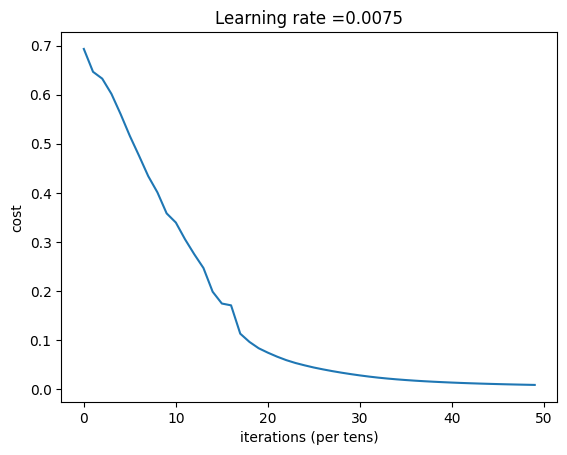

In [56]:
n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

parameters = two_layer_model(train_x, train_set_y, layers_dims=(n_x, n_h, n_y), num_iterations=5000,
                             print_cost=True, isPlot=True)

### 2.1 预测函数实现
在对模型进行训练之后，接着我们需要定义预测函数进行预测，代码实现如下：

In [57]:
def predict(X, y, parameters):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层
    
    参数：
     X - 测试集
     y - 标签
     parameters - 训练模型的参数
    
    返回：
     p - 给定数据集X的预测
    """

    m = X.shape[1]
    n = len(parameters) // 2  # 神经网络的层数
    p = np.zeros((1, m))

    #根据参数前向传播
    probas, caches = L_model_forward(X, parameters)

    for i in range(0, probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0

    print("准确度为: " + str(float(np.sum((p == y)) / m)))

    return p

构建好预测函数后就可以使用训练好的模型进行预测，并查看训练集和测试集的准确性。

In [58]:
predictions_train = predict(train_x, train_y, parameters)  #训练集
predictions_test = predict(test_x, test_y, parameters)  #测试集

准确度为: 1.0
准确度为: 0.7


## 3 搭建多层神经网络模型<span id='6'></span>
接下来，你需要**搭建多层神经网络模型L_layer_model()**，该网络模型的结构如下图所示：

![](data/3-3.png)
**要点**：

- 参照两层神经网络模型的实现过程，将其扩展为多层神经网络模型
- 并设置打印成本值的选项，每迭代100次进行打印
- 对训练过程中计算的成本值进行绘图

In [59]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False, isPlot=True):
    """
    实现一个L层神经网络：[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID。
    
    参数：
	    X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,···,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    
    返回：
     parameters - 模型学习的参数。 然后他们可以用来预测。
    """
    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate)

        #打印成本值，如果print_cost=False则忽略
        if i % 100 == 0:
            #记录成本
            costs.append(cost)
            #是否打印成本值
            if print_cost:
                print("第", i, "次迭代，成本值为：", np.squeeze(cost))
    #迭代完成，根据条件绘制图
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    return parameters

第 0 次迭代，成本值为： 0.715731513413713
第 100 次迭代，成本值为： 0.6747377593469114
第 200 次迭代，成本值为： 0.6603365433622128
第 300 次迭代，成本值为： 0.6462887802148751
第 400 次迭代，成本值为： 0.6298131216927773
第 500 次迭代，成本值为： 0.606005622926534
第 600 次迭代，成本值为： 0.5690041263975135
第 700 次迭代，成本值为： 0.519796535043806
第 800 次迭代，成本值为： 0.46415716786282285
第 900 次迭代，成本值为： 0.40842030048298916
第 1000 次迭代，成本值为： 0.37315499216069037
第 1100 次迭代，成本值为： 0.30572374573047123
第 1200 次迭代，成本值为： 0.26810152847740853
第 1300 次迭代，成本值为： 0.23872474827672546
第 1400 次迭代，成本值为： 0.20632263257914704
第 1500 次迭代，成本值为： 0.17943886927493496
第 1600 次迭代，成本值为： 0.1579873581880092
第 1700 次迭代，成本值为： 0.14240413012273553
第 1800 次迭代，成本值为： 0.12865165997883937
第 1900 次迭代，成本值为： 0.11244314998149502
第 2000 次迭代，成本值为： 0.0850563103495609
第 2100 次迭代，成本值为： 0.05758391198598445
第 2200 次迭代，成本值为： 0.044567534546903216
第 2300 次迭代，成本值为： 0.03808275166595923
第 2400 次迭代，成本值为： 0.034410749018391744
第 2500 次迭代，成本值为： 0.03173223335175764
第 2600 次迭代，成本值为： 0.02978190297349405
第 2700 次迭代，成本值为： 0.02822

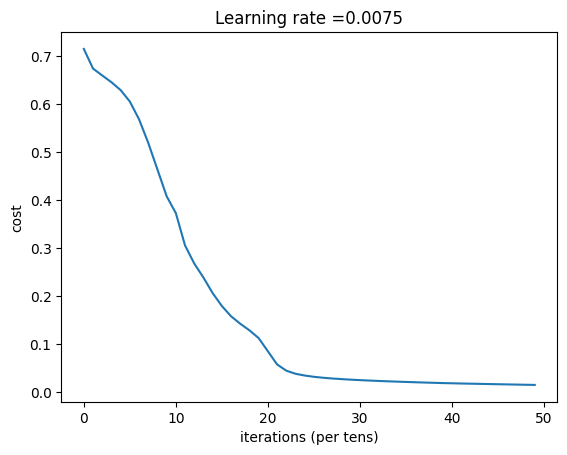

In [60]:
#训练你的模型L_layer_model
layers_dims = [12288, 20, 7, 5, 1]  #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations=5000, print_cost=True, isPlot=True)


In [61]:
pred_train = predict(train_x, train_y, parameters)  #训练集
pred_test = predict(test_x, test_y, parameters)  #测试集

准确度为: 0.9952153110047847
准确度为: 0.78


你可以看到设置不同层数的神经网络模型的效果对比。